# Corn Disease Classification

The aim of this project is to buil models (specifically neural networks) that are able to classify images of corn leaves based on a specific disease.

The different diseases are:
- **Blight**: foliar disease of corn (maize) caused by a parasite. With its characteristic cigar-shaped lesions, this disease can cause significant yield loss in susceptible corn hybrids;
- **Common Rust**: caused by the a fungus and occurs every growing season. It is seldom a concern in hybrid corn. Early symptoms of common rust are chlorotic flecks on the leaf surface;
- **Gray Leaf Spot**: it is a foliar fungal disease that affects maize. GLS is considered one of the most significant yield-limiting diseases of corn worldwide. There are two fungal pathogens that cause GLS. Symptoms seen on corn include leaf lesions, discoloration (chlorosis), and foliar blight;
- **Healthy**: this is not properly a disease but in order to make an all around classification there has been included also the healthy leaves.

After briefly discussing some tecnical aspects about biology let's jump into something more interesting for us.

We started with a folder, divided into subfolders, containing the different leaf images divided according to the disease. The first step was to build an actual dataset.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from PIL.ImageOps import crop, flip, mirror
import os
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input
from keras.applications import VGG16
from keras.models import Model

from tensorflow.keras.utils import plot_model

warnings.filterwarnings('ignore')

2024-02-02 15:57:52.520720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 15:57:52.520816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 15:57:52.649800: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading

In [7]:
RANDOM_STATE = 42 # setting a constant random state for every method that uses randomization

In [8]:
def create_data():
    name = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
    final_images = []
    final_labels = []

    for disease in name:
        folder_path = '/kaggle/input/Corn Images/' + disease
        images = []
        labels = [disease] * len(os.listdir(folder_path))

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            images.append(img)

        final_images.extend(images)
        final_labels.extend(labels)

    return final_images, final_labels

In [9]:
result = create_data()
dataset = pd.DataFrame({'Image': result[0], 'Label': result[1]})

In [10]:
# a check to see if all the images have been loaded
print(dataset[dataset['Label'] == 'Blight'].count())
print(dataset[dataset['Label'] == 'Common_Rust'].count())
print(dataset[dataset['Label'] == 'Gray_Leaf_Spot'].count())
print(dataset[dataset['Label'] == 'Healthy'].count())

Image    1146
Label    1146
dtype: int64
Image    1306
Label    1306
dtype: int64
Image    574
Label    574
dtype: int64
Image    1162
Label    1162
dtype: int64


In [11]:
display(dataset.head(10))

Image   Label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
5  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
6  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
7  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
8  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight
9  <PIL.JpegImagePlugin.JpegImageFile image mode=...  Blight

## Data Visualization

In [12]:
def show_image(image):
    image = image.copy()
    plt.imshow(image, aspect='equal')

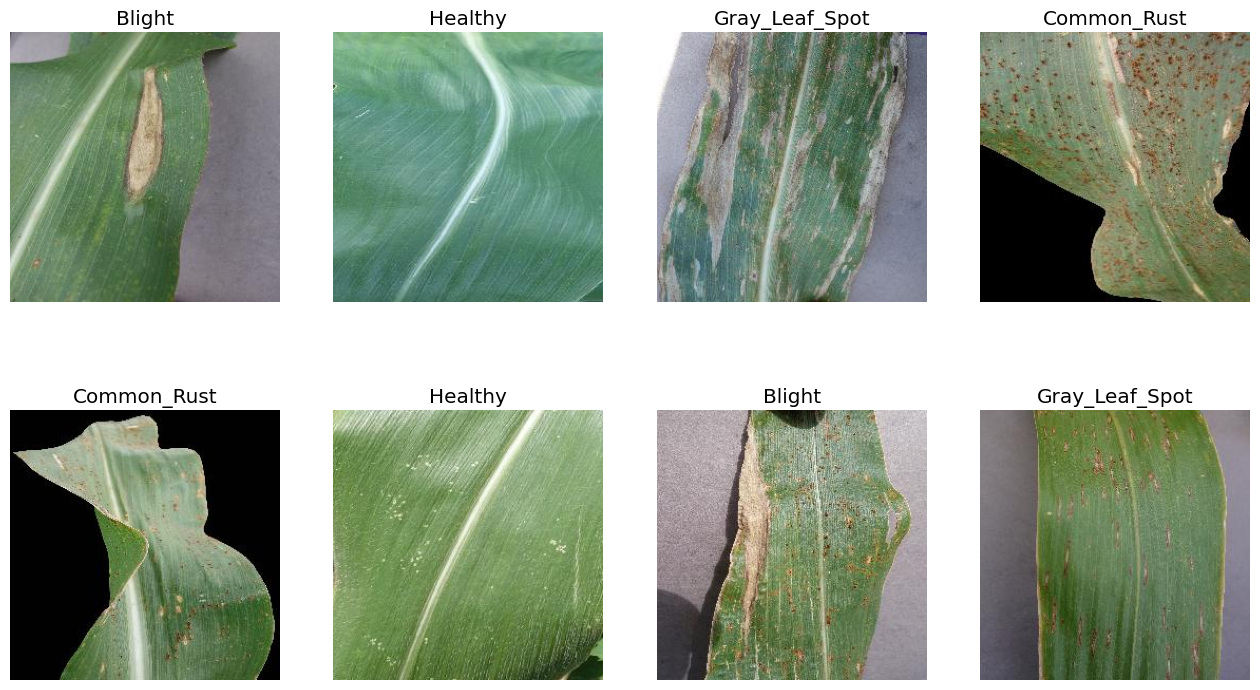

In [13]:
plt.style.use('ggplot')
rng = np.random.default_rng(RANDOM_STATE)
n_cols = 4
n_rows = 2
indexes = rng.choice(len(dataset), n_cols * n_rows)

plt.figure(figsize=(16, 9))

for ii, id in enumerate(indexes, 1):
    plt.subplot(n_rows, n_cols, ii)
    image = dataset['Image'][int(id)]
    show_image(image)
    plt.title(dataset['Label'][int(id)])
    plt.axis('off')

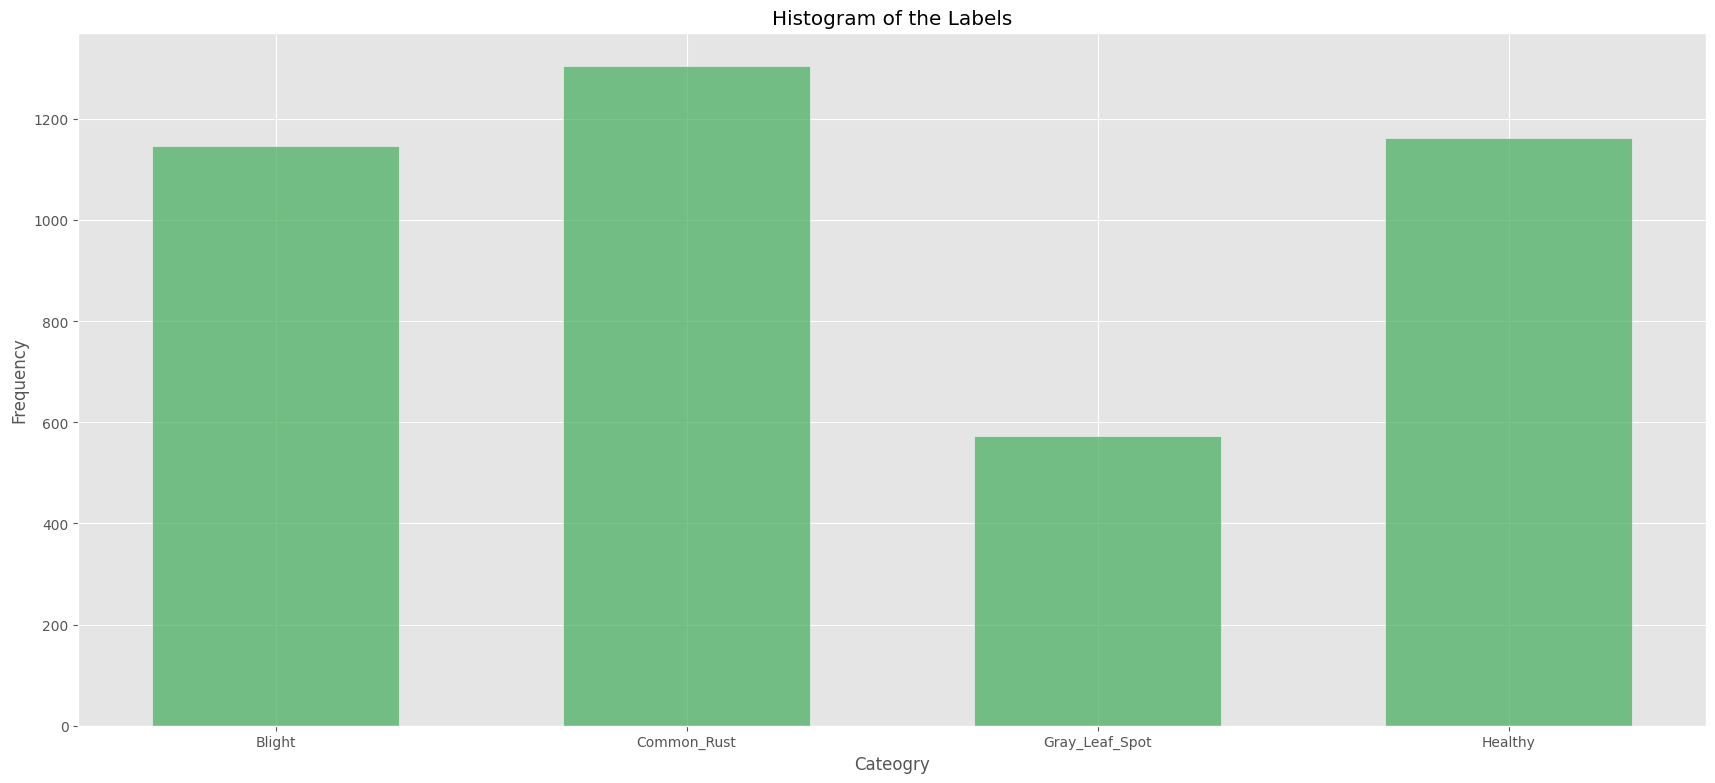

In [14]:
plt.style.use('ggplot')
palette = sns.color_palette('Greens', 4)

plt.figure(figsize=(21, 9))
sns.histplot(dataset['Label'], bins=4, shrink=0.6, kde=False, color=palette[2])

plt.xlabel('Cateogry')
plt.ylabel('Frequency')
plt.title('Histogram of the Labels')

# Show the plot
plt.show()

In [15]:
x = dataset[['Image', 'Label']] # using another variable to leave the original dataset intact

## Data Preparation

After spending some time trying to understand why we couldn't train our model, we finally understood why: few images were not in a RGB (we take it for granted since they finding an image with another format is not very usual) but they were stored in RGBA or CMYK so they had 4 channels. We found them and converted in RGB to leave the size and all the other computations intact.

In [16]:
for i in range(len(x)):
    im = x["Image"][i]
    if im.mode != "RGB":
        print(im.mode, "Index:", i, end=" --> ")
        x["Image"][i] = x["Image"][i].convert("RGB")
        print("Converted in RGB")

RGBA Index: 1406 --> Converted in RGB
RGBA Index: 1479 --> Converted in RGB
RGBA Index: 1793 --> Converted in RGB
CMYK Index: 2676 --> Converted in RGB
RGBA Index: 2844 --> Converted in RGB


In [17]:
X_train, X_val, y_train, y_val = train_test_split(x['Image'], x['Label'], test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=x['Label'])

In [18]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

X_train shape: (3350,)
X_val shape: (838,)
y_train shape: (3350,)
y_val shape: (838,)


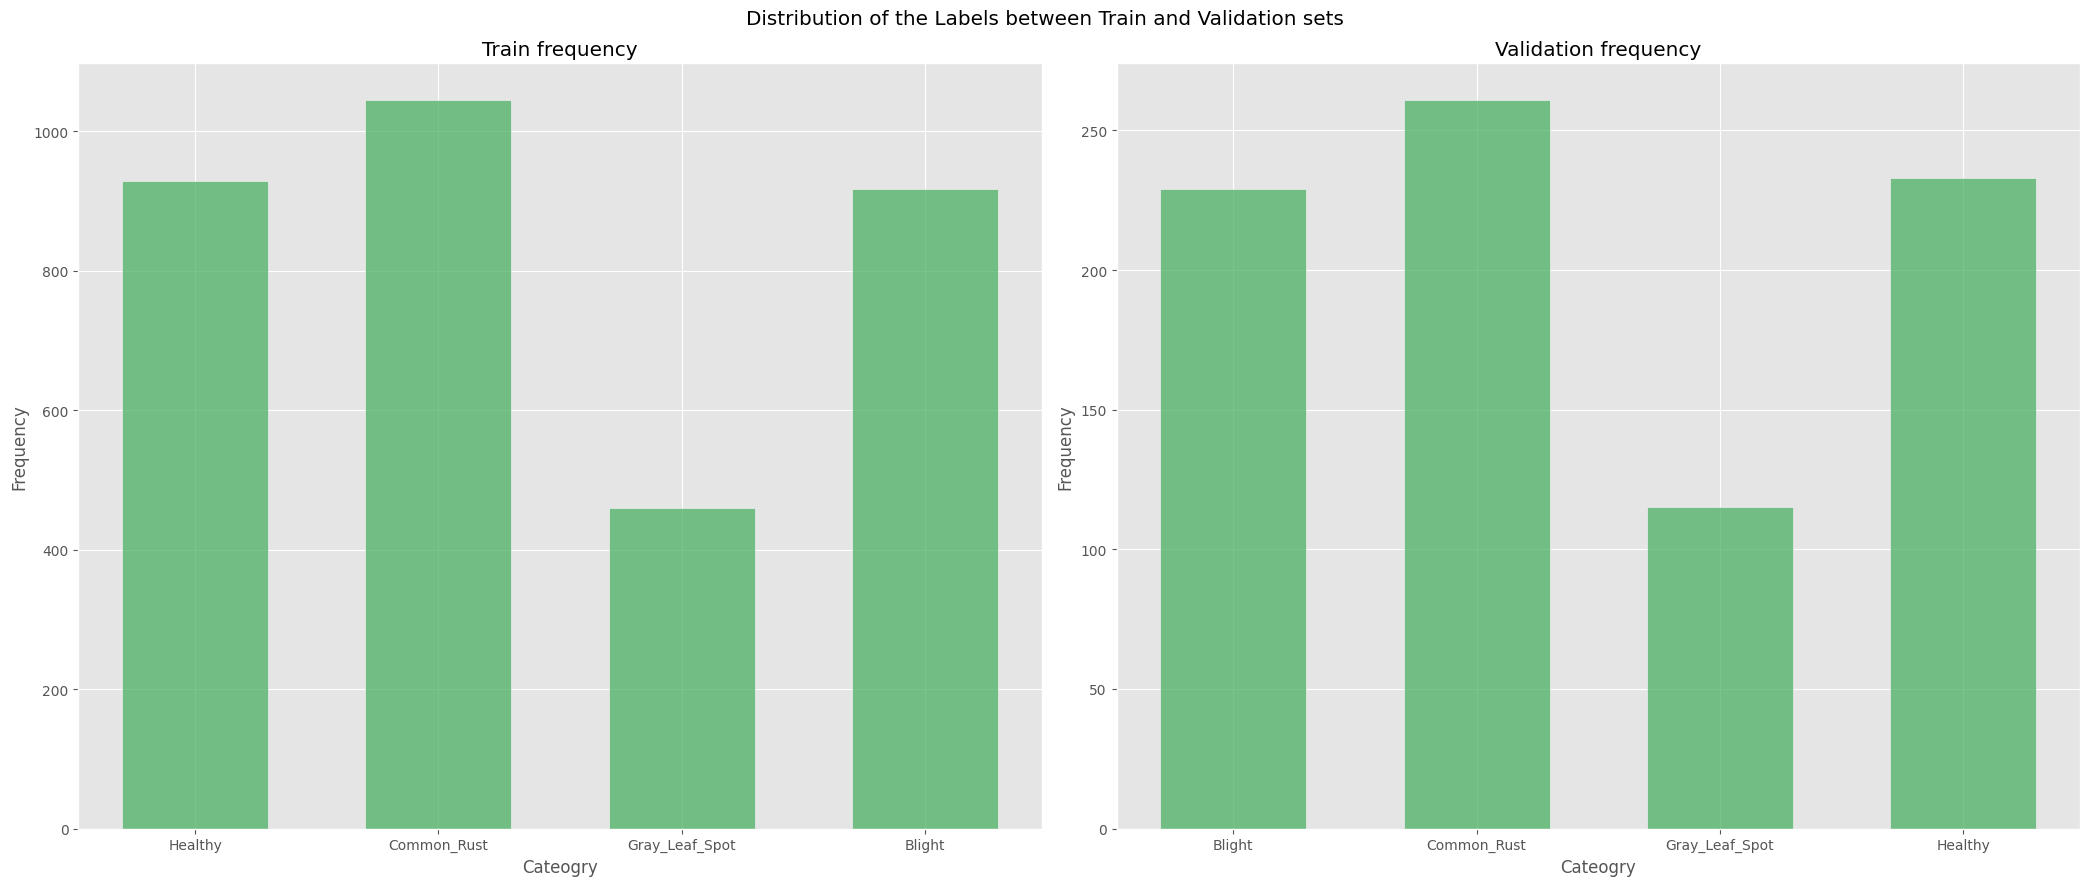

In [19]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9), tight_layout=True)

sns.histplot(y_train, bins=4, shrink=0.6, kde=False, color=palette[2], ax=ax1)

ax1.set_xlabel('Cateogry')
ax1.set_ylabel('Frequency')
ax1.set_title('Train frequency')

sns.histplot(y_val, bins=4, shrink=0.6, kde=False, color=palette[2], ax=ax2)

ax2.set_xlabel('Cateogry')
ax2.set_ylabel('Frequency')
ax2.set_title('Validation frequency')

plt.suptitle('Distribution of the Labels between Train and Validation sets', size='x-large')


# Show the plot
plt.show()

As we can see adding the stratify attribute to the split was successful since the numbers of labels per disease has remained equal between the two sets

## Data Augmentation

The Data Augmentation process is fundamental when dealing with images. This process involves applying some transformations to the original images in order to "create" other examples to train the network. After the process the user can decided to either mantain both the images (Augmented and not) or only use augmented images. We have procedeed with the second option.

In out case the path was:
- Resizing: (224x224)
- Rotation: from -45 to 45 degrees
- Horizontal Flip
- Vertical Flip
- Zoom: from 0 to 50 pixels
- Contrast
- Brightness

All these adjustments has been made through a probability, so if a number chosen randomly was lower than 0.2 then the adjustment was applied

In [20]:
np.random.seed(RANDOM_STATE)

In [21]:
def Resize(content):
    return content.resize((224, 224))

In [22]:
def RandomRotation(content):
    p = 0.2
    if np.random.random() < p:
        return content.rotate(np.random.randint(-45, 45))
    else:
        return content

In [23]:
def RandomHorizontalFlip(content):
    p = 0.2
    if np.random.random() < p:
        return mirror(content)
    else:
        return content

In [24]:
def RandomVerticalFlip(content):
    p = 0.2
    if np.random.random() < p:
        return flip(content)
    else:
        return content

In [25]:
def RandomZoom(content):
    p = 0.2
    if np.random.random() < p:
        cropped = crop(content, np.random.randint(0, 50))
        return cropped.resize((224, 224))
    else:
        return content

In [26]:
def AdjustContrast(content):
    p = 0.2
    if np.random.random() < p:
        return ImageEnhance.Contrast(content).enhance(np.random.uniform(0.5, 1.5))
    else:
        return content

In [27]:
def AdjustBrightness(content):
    p = 0.2
    if np.random.random() < p:
        return ImageEnhance.Brightness(content).enhance(np.random.uniform(0.5, 1.5))
    else:
        return content

In [28]:
def DataAugmentation(content):
    content = RandomRotation(content)
    content = RandomHorizontalFlip(content)
    content = RandomVerticalFlip(content)
    content = RandomZoom(content)
    content = AdjustContrast(content)
    content = AdjustBrightness(content)
    return content

In [29]:
X_train = X_train.apply(Resize)
X_val = X_val.apply(Resize)

In [30]:
X_train = X_train.apply(DataAugmentation)

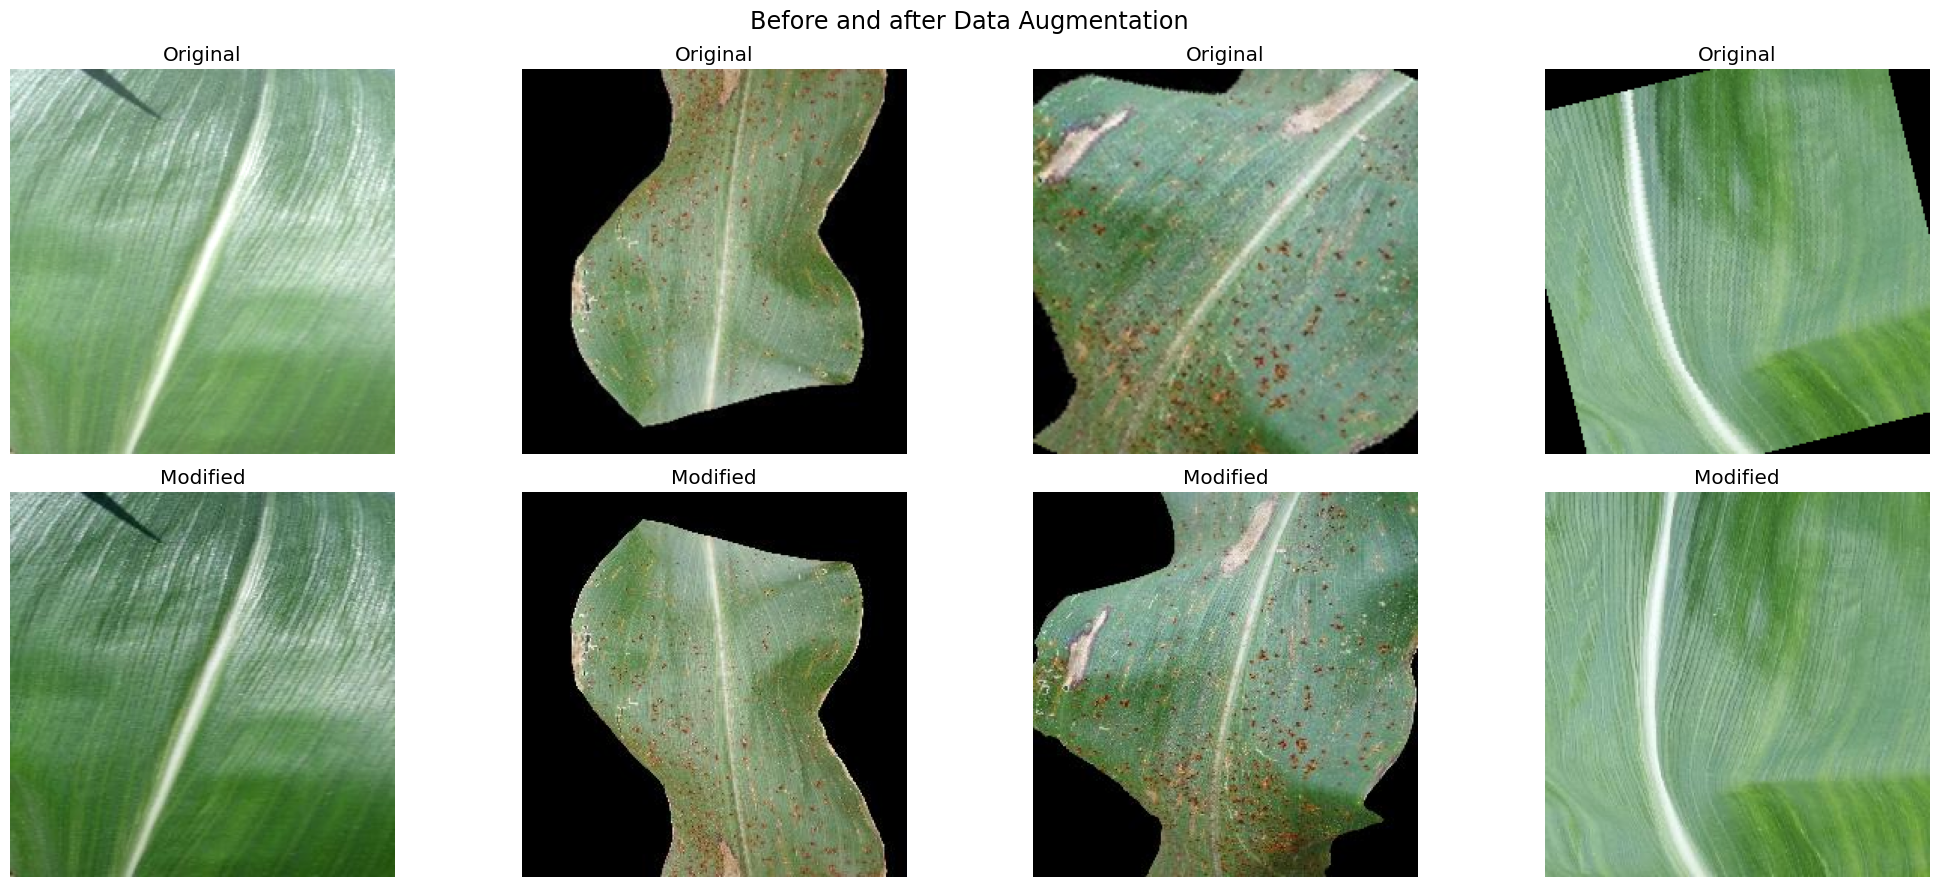

In [31]:
plt.style.use('ggplot')
n_rows = 2  
n_cols = 4
index_total = X_train.index
indexes = index_total[:5]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(21,9), tight_layout=True)

for i in range(n_cols):
    ax = axes[0, i]
    ax.imshow(X_train[indexes[i]])
    ax.set_title("Original")
    ax.axis("off")
    
    ax = axes[1, i]
    ax.imshow(x["Image"][indexes[i]])
    ax.set_title("Modified")
    ax.axis("off")

plt.suptitle('Before and after Data Augmentation', size = 'xx-large')

plt.show()

In [32]:
def ToNumpy(content):
    return np.asarray(content, dtype=np.float32)

In [33]:
X_train = X_train.apply(ToNumpy)
X_val = X_val.apply(ToNumpy)

In [34]:
def Rescaling(content):
    return content / 255.0

In [35]:
X_train = X_train.apply(Rescaling)
X_val = X_val.apply(Rescaling)

In [36]:
X_train = X_train.values
X_val = X_val.values
y_val = y_val.values
y_train = y_train.values

In [37]:
trainX = []
for im in X_train:
    trainX.append(im)
trainX = np.array(trainX)

In [38]:
valX = []
for im in X_val:
    valX.append(im)
valX = np.array(valX)

In [39]:
print(trainX.shape)
print(valX.shape)

(3350, 224, 224, 3)
(838, 224, 224, 3)


In [40]:
train_X = trainX.reshape(trainX.shape[0], 224*224*3)

Since one of the four category had a slight imabalance compared to the others we decided to apply SMOTE oversampling. The SMOTE tecnique basically creates artificial images based on the minority class and finally raise all the categories to the same amount of examples

In [41]:
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(train_X, y_train)

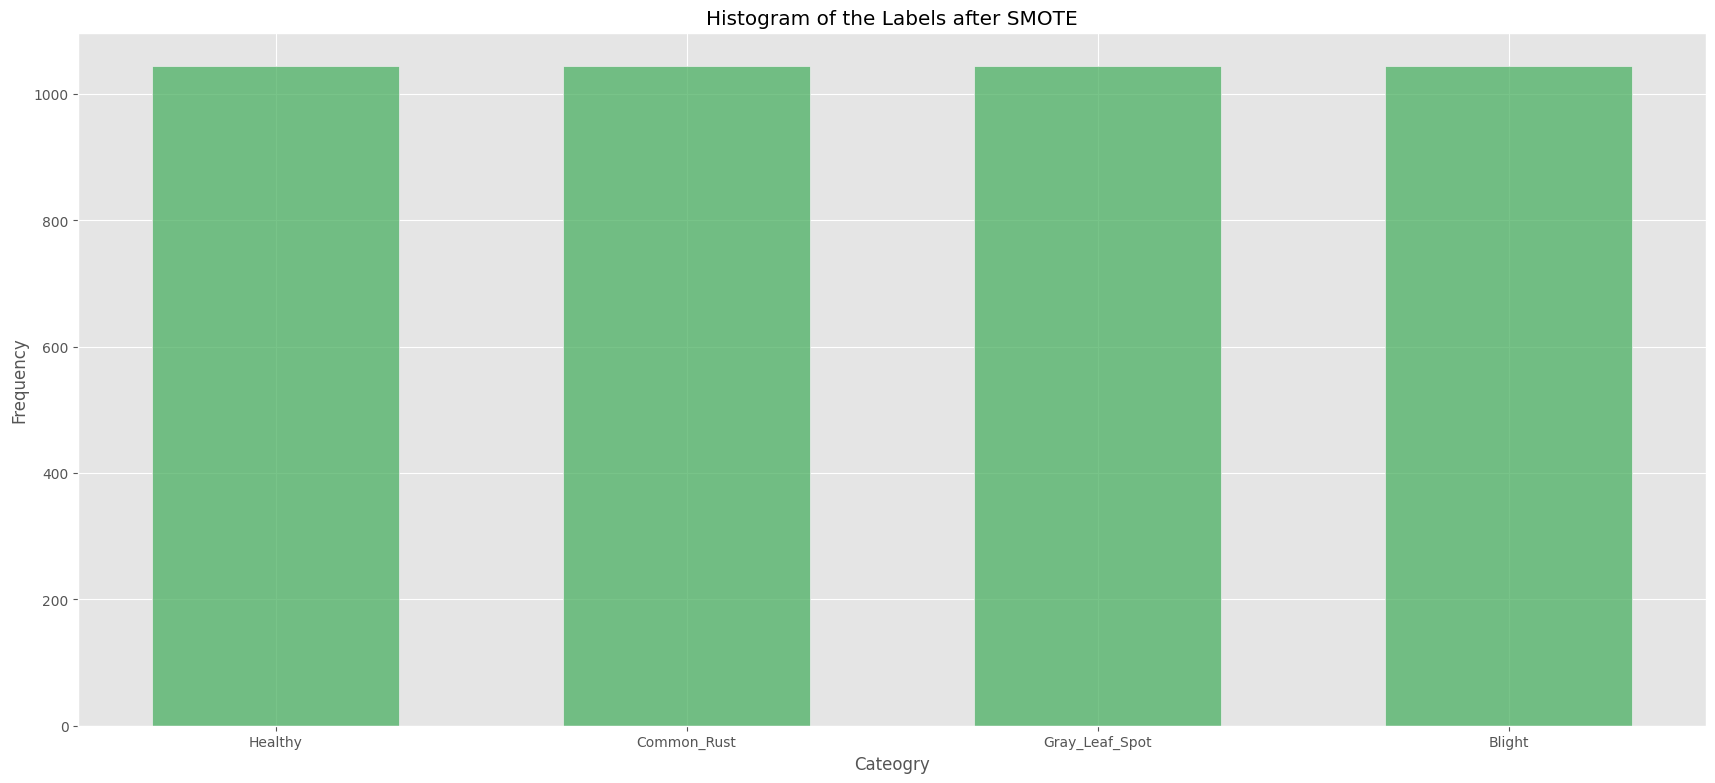

In [42]:
plt.style.use('ggplot')
plt.figure(figsize=(21, 9))
sns.histplot(y_smote, bins=4, shrink=0.6, kde=False, color=palette[2])

plt.xlabel('Cateogry')
plt.ylabel('Frequency')
plt.title('Histogram of the Labels after SMOTE')

# Show the plot
plt.show()

In [43]:
X_smote = X_smote.reshape(X_smote.shape[0], 224, 224, 3)

In [66]:
enc = OneHotEncoder()

Y_train = enc.fit_transform(y_smote[:, np.newaxis]).toarray()
Y_val = enc.transform(y_val[:, np.newaxis]).toarray()
trainY = enc.transform(y_train[:, np.newaxis]).toarray()

## Data Modelling

### C-CNN

In [45]:
input_shape = (224, 224, 3)

In [70]:
classifier = Sequential()

classifier.add(Input(shape=input_shape))

classifier.add(Conv2D(16, (3, 3), input_shape=input_shape, activation='relu', kernel_initializer='random_normal', strides=(1, 1), name = 'conv2D16'))
classifier.add(MaxPooling2D(pool_size=(2, 2), name = 'maxpooling2D'))

classifier.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', kernel_initializer='random_normal', strides=(1, 1), name = 'conv2D32'))
classifier.add(MaxPooling2D(pool_size=(2, 2), name = 'maxpooling2D1'))

classifier.add(Dropout(0.7, name = 'dropout'))

classifier.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu', kernel_initializer='random_normal', strides=(1, 1), name = 'conv2D64'))
classifier.add(MaxPooling2D(pool_size=(2, 2), name = 'maxpooling2D2'))

classifier.add(Dropout(0.7, name = 'dropout1'))

classifier.add(Flatten(name = 'flatten'))

classifier.add(Dense(units=4, activation='softmax', kernel_initializer='random_normal', name = 'Softmaxdense'))


classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2D16 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 maxpooling2D (MaxPooling2D  (None, 111, 111, 16)      0         
 )                                                               
                                                                 
 conv2D32 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 maxpooling2D1 (MaxPooling2  (None, 54, 54, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 54, 54, 32)        0         
                                                                 
 conv2D64 (Conv2D)           (None, 52, 52, 64)        1

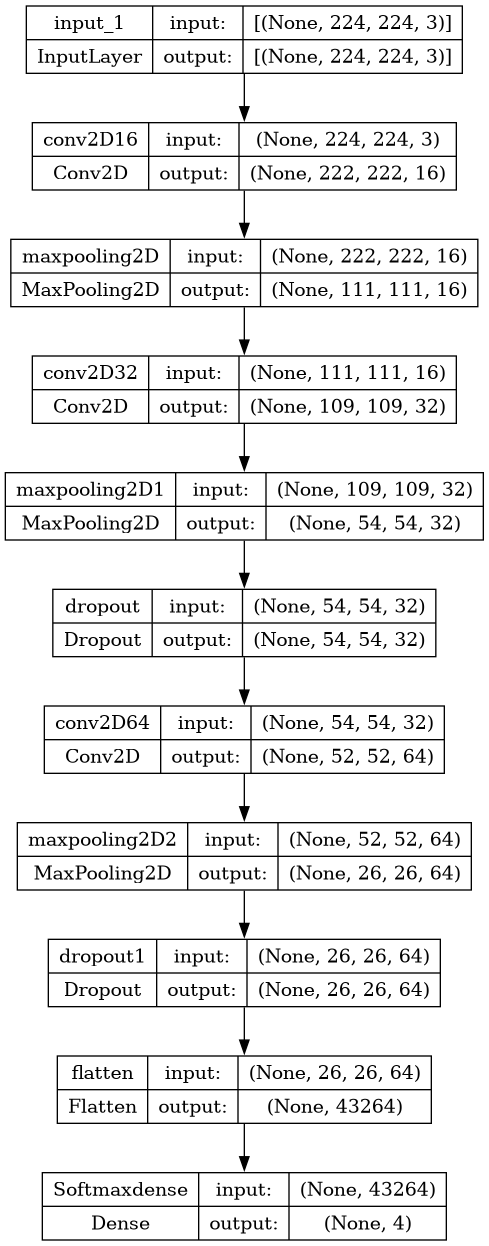

In [48]:
plot_model(classifier, to_file='C-CNN.png', show_shapes=True, show_layer_names=True)

In [71]:
classifier_no_SMOTE = tf.keras.models.clone_model(classifier)

### C-CNN with SMOTE

In [51]:
# training with SMOTE
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.01, mode="max", patience = 3)
]

history_SMOTE = classifier.fit(X_smote, Y_train, batch_size=32, epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50


2024-02-02 16:03:03.154538: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706889785.811524     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 [==============================] - 9s 31ms/step - loss: 1.0633 - accuracy: 0.5189
Epoch 2/50
131/131 [==============================] - 3s 26ms/step - loss: 0.6267 - accuracy: 0.7249
Epoch 3/50
131/131 [==============================] - 3s 26ms/step - loss: 0.5224 - accuracy: 0.7787
Epoch 4/50
131/131 [==============================] - 3s 26ms/step - loss: 0.4672 - accuracy: 0.8144
Epoch 5/50
131/131 [==============================] - 3s 26ms/step - loss: 0.4566 - accuracy: 0.8256
Epoch 6/50
131/131 [==============================] - 3s 26ms/step - loss: 0.4232 - accuracy: 0.8337
Epoch 7/50
131/131 [==============================] - 3s 26ms/step - loss: 0.4570 - accuracy: 0.8172
Epoch 8/50
131/131 [==============================] - 3s 26ms/step - loss: 0.3848 - accuracy: 0.8524
Epoch 9/50
131/131 [==============================] - 3s 26ms/step - loss: 0.4054 - accuracy: 0.8471
Epoch 10/50
131/131 [==============================] - 3s 26ms/step - loss: 0.3811 - accuracy: 0.8553


In [52]:
classifier.save("Model_with_SMOTE")

In [53]:
history_df_SMOTE = pd.DataFrame(history_SMOTE.history)
history_df_SMOTE.head()

loss  accuracy
0  1.063309  0.518900
1  0.626741  0.724880
2  0.522411  0.778708
3  0.467223  0.814354
4  0.456589  0.825598

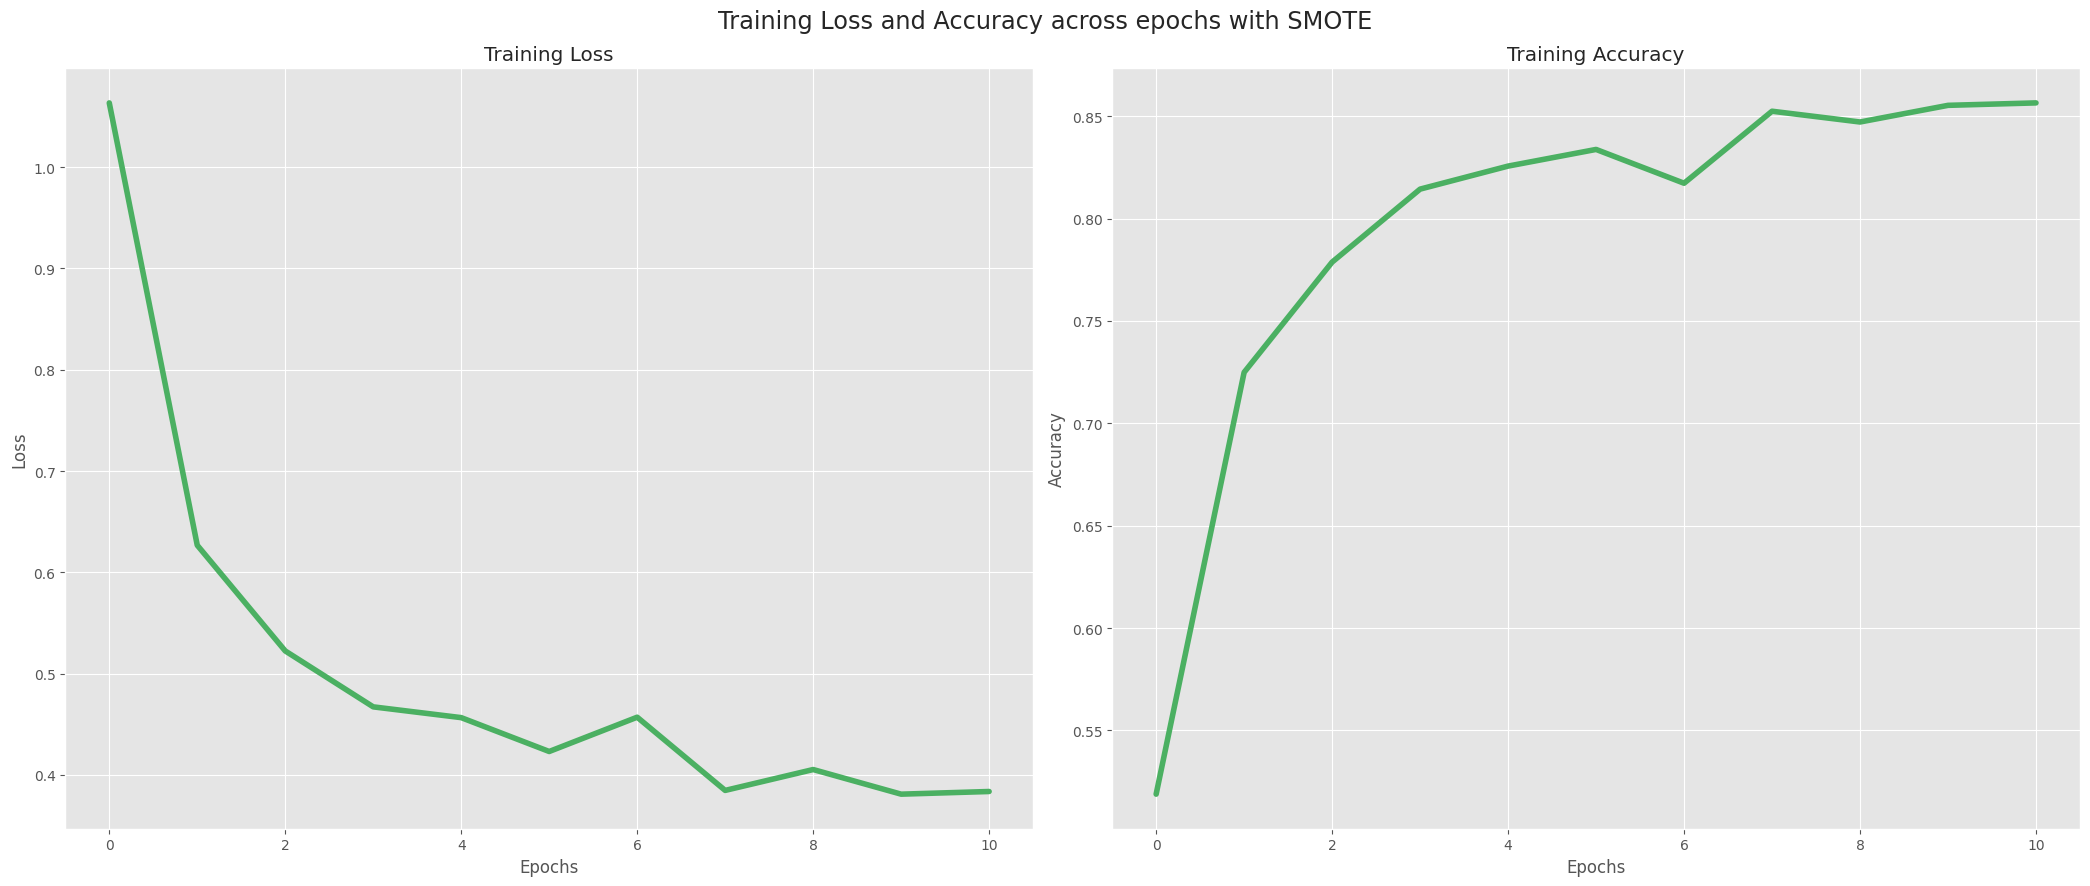

In [96]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9), tight_layout=True)

history_df_SMOTE['loss'].plot(ax = ax1, linewidth = 4, color = palette[2])

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')

history_df_SMOTE['accuracy'].plot(ax = ax2, linewidth = 4, color = palette[2])

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.suptitle('Training Loss and Accuracy across epochs with SMOTE', size='xx-large')


# Show the plot
plt.show()

In [55]:
classifier.evaluate(valX, Y_val)

27/27 [==============================] - 1s 17ms/step - loss: 0.4781 - accuracy: 0.8150


[0.4780750274658203, 0.8150358200073242]

In [56]:
prediction = classifier.predict(valX)

27/27 [==============================] - 0s 10ms/step


In [57]:
def from_number_to_label(number, encoder=enc):
    vector = np.zeros(4)
    vector[number] = 1
    return encoder.inverse_transform([vector])[0][0]

In [58]:
predictions = prediction.argmax(axis=1)
prediction_labels = []
for n in predictions:
    prediction_labels.append(from_number_to_label(n))

In [59]:
actual_test = Y_val.argmax(axis=1)
actual_test_labels = []
for n in actual_test:
    actual_test_labels.append(from_number_to_label(n))

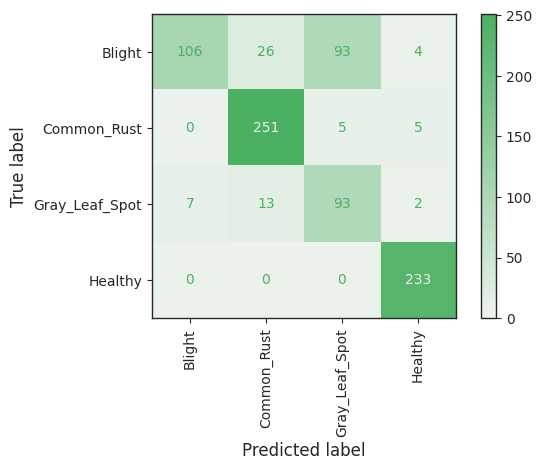

In [60]:
cmap = sns.light_palette(color=sns.color_palette("Greens", 4)[2], as_cmap=True)
sns.set_style("ticks")
ConfusionMatrixDisplay.from_predictions(y_true=actual_test_labels,
                                        y_pred=prediction_labels,
                                        cmap=cmap,
                                        xticks_rotation=90,
                                       )
plt.tight_layout()
plt.show()

As we can see the most confused classes are Blight and Gray Leaf Spot, which is understandable as they are both diseases that affect the leaves of the corn plant. The model is also having a hard time distinguishing between Common Rust and Gray Leaf Spot, which is also understandable as they are both diseases that affect the leaves of the corn plant.

The precision of the class 'Gray_Leaf_Spot' is low (49%), the model very often predict Gray Leaf Spot when the real label is Blight. On the other hand the recall of the Blight class is very low (46%) so that means that the model very often is not able to detect Blight disease.

In [61]:
def predict_single_image(image) -> str:
    index_label = classifier.predict(np.array([image]), verbose=0).argmax()
    vector = np.zeros(4)
    vector[index_label] = 1
    return enc.inverse_transform([vector])[0][0]

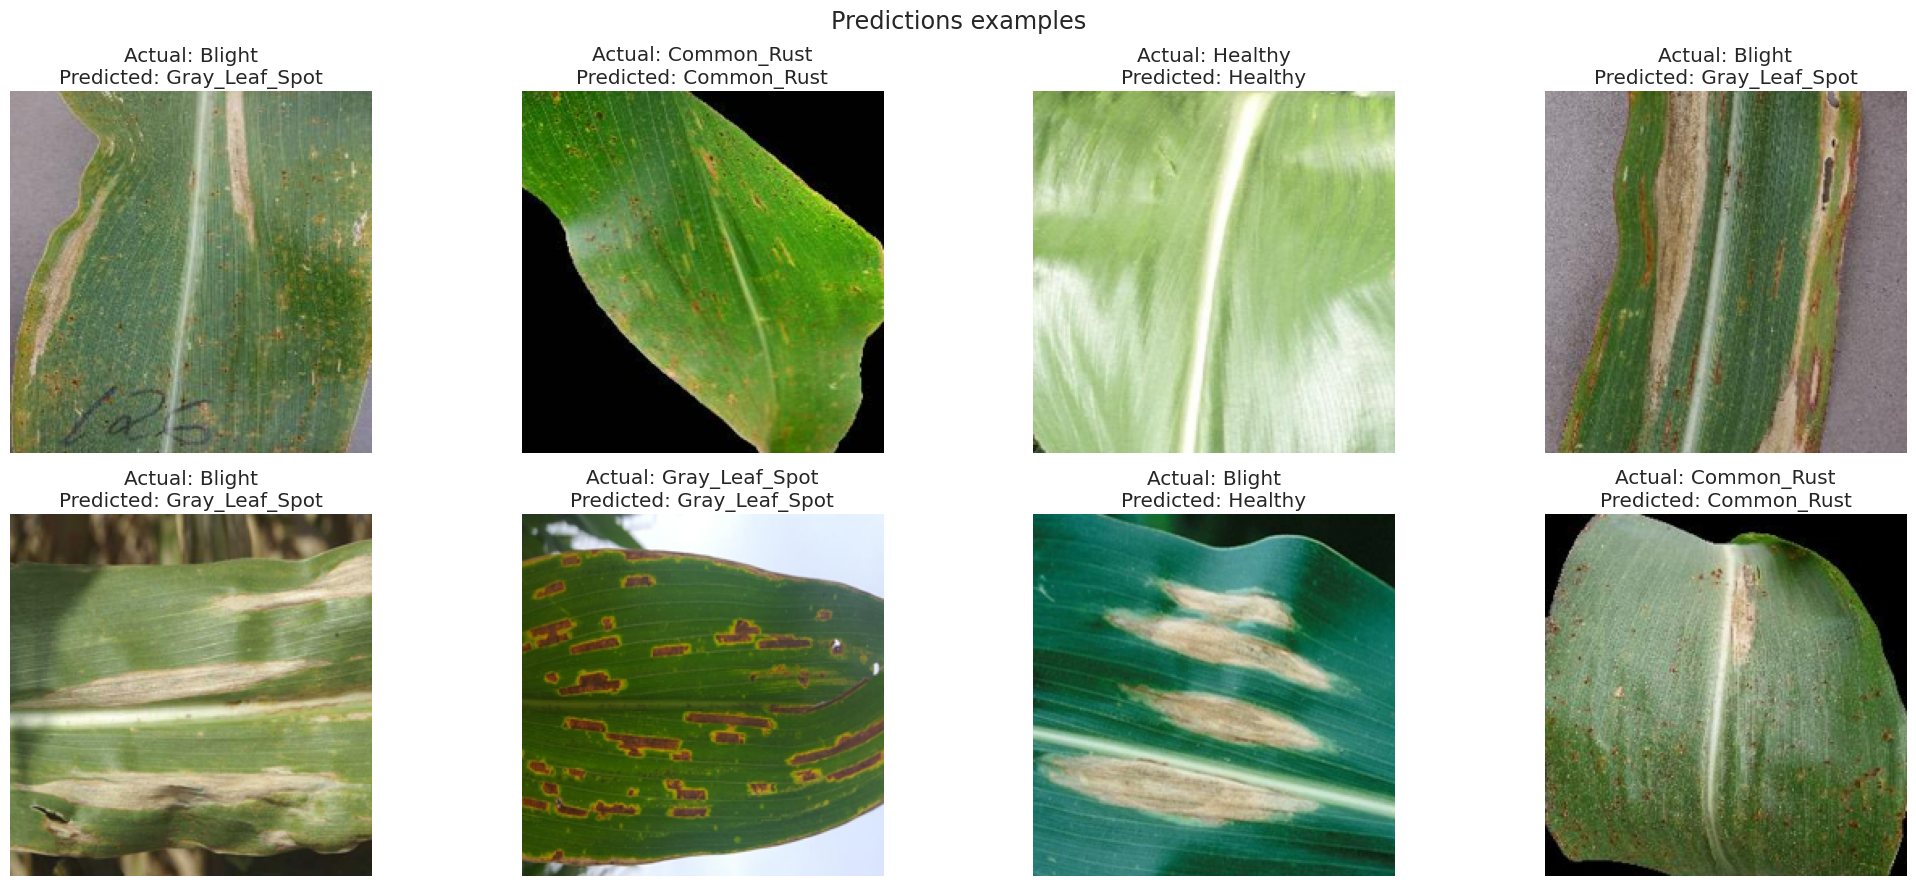

In [62]:
plt.style.use('ggplot')
rng = np.random.default_rng(RANDOM_STATE)
n_cols = 4
n_rows = 2
indexes = rng.choice(len(valX), n_cols * n_rows)
images = [valX[index] for index in indexes]
true_labels = [Y_val[index] for index in indexes]
predicted_labels = [predict_single_image(valX[index]) for index in indexes]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 9), tight_layout=True)

for i, image, actual_lab, pred_lab in zip(range(n_cols*n_rows), images, true_labels, predicted_labels):
    ax = axes[i // n_cols, i % n_cols]
    ax.imshow(image)
    title = "Actual: {}\nPredicted: {}".format(enc.inverse_transform(actual_lab.reshape(1, -1))[0][0], pred_lab)
    ax.set_title(title)
    ax.axis("off")

plt.suptitle("Predictions examples", fontsize="xx-large")
plt.show()

In [63]:
error_indexes = []
for i in range(len(prediction_labels)):
    if prediction_labels[i] != actual_test_labels[i]:
        error_indexes.append(i)

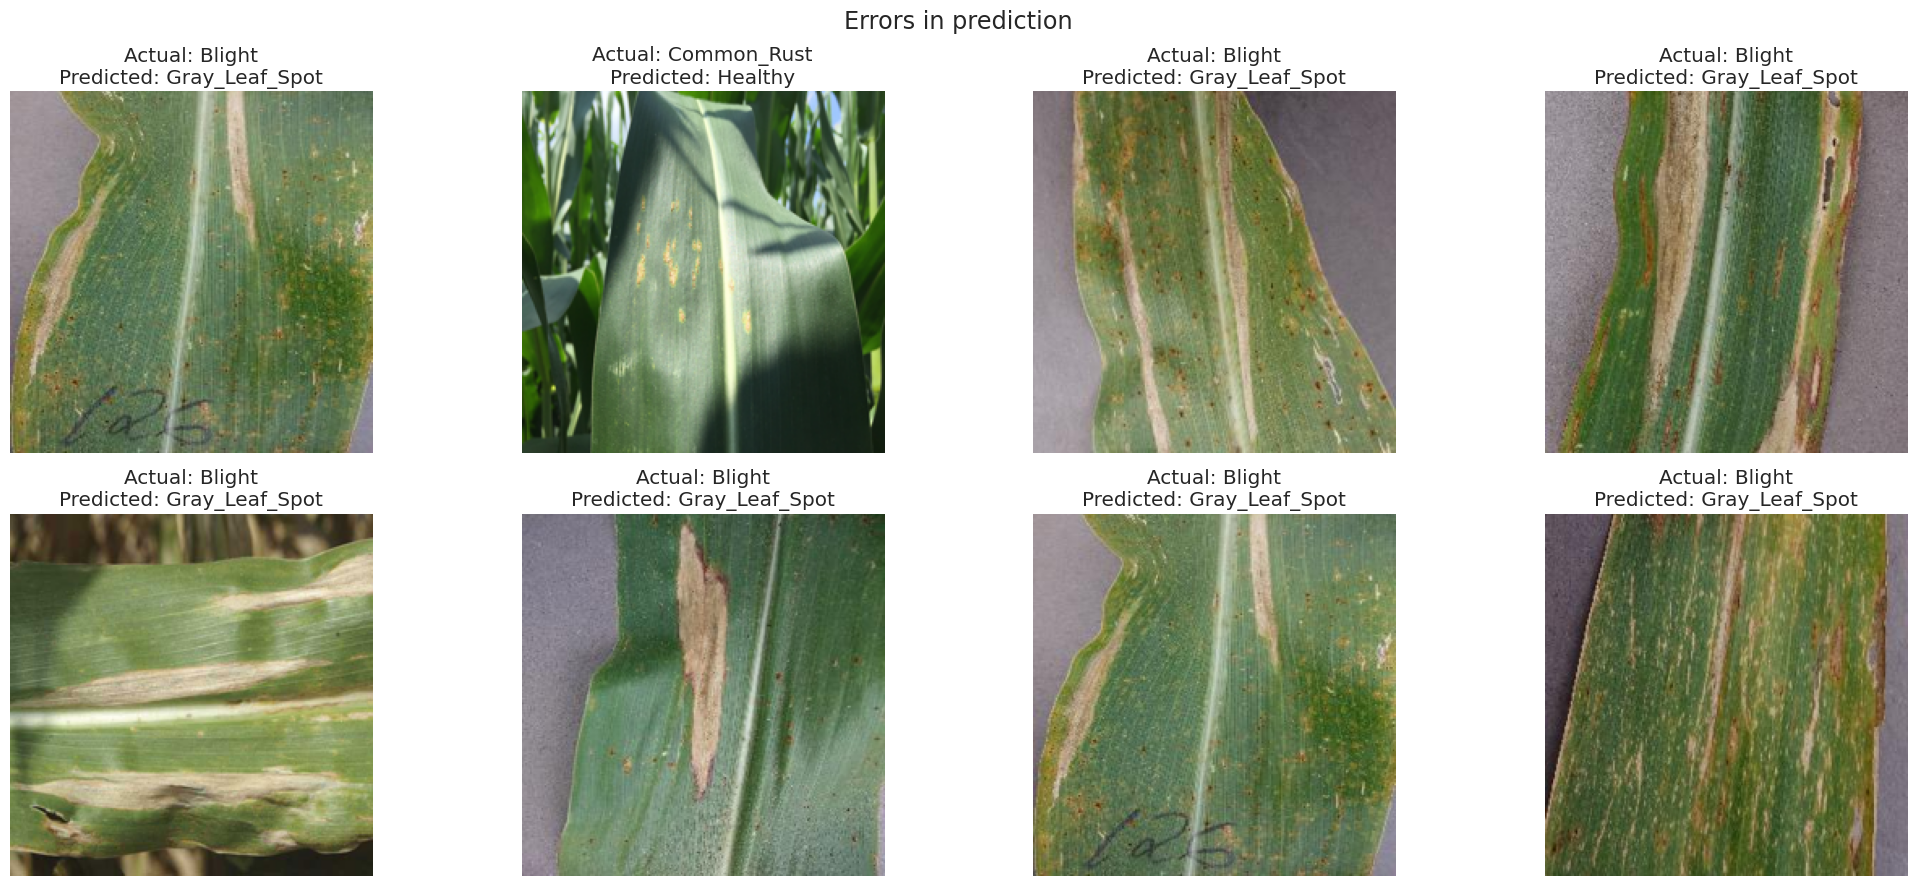

In [64]:
plt.style.use('ggplot')
rng = np.random.default_rng(RANDOM_STATE)

n_cols = 4
n_rows = 2

indexes = rng.choice(error_indexes, n_cols * n_rows)

images = [valX[index] for index in indexes]
true_labels = [Y_val[index] for index in indexes]
predicted_labels = [predict_single_image(valX[index]) for index in indexes]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 9), tight_layout=True)

for i, image, actual_lab, pred_lab in zip(range(n_cols*n_rows), images, true_labels, predicted_labels):
    ax = axes[i // n_cols, i % n_cols]
    ax.imshow(image)
    title = "Actual: {}\nPredicted: {}".format(enc.inverse_transform(actual_lab.reshape(1, -1))[0][0], pred_lab)
    ax.set_title(title)
    ax.axis("off")

plt.suptitle("Errors in prediction", fontsize="xx-large")
plt.show()

### C-CNN without SMOTE

In [73]:
classifier_no_SMOTE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_no_SMOTE = classifier_no_SMOTE.fit(trainX, trainY, epochs = 50, callbacks = callbacks, batch_size = 32, verbose = 1)

Epoch 1/50


2024-02-02 16:13:49.061717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


105/105 [==============================] - 4s 26ms/step - loss: 1.0841 - accuracy: 0.5307
Epoch 2/50
105/105 [==============================] - 3s 26ms/step - loss: 0.6164 - accuracy: 0.7427
Epoch 3/50
105/105 [==============================] - 3s 26ms/step - loss: 0.5105 - accuracy: 0.7845
Epoch 4/50
105/105 [==============================] - 3s 26ms/step - loss: 0.4531 - accuracy: 0.8122
Epoch 5/50
105/105 [==============================] - 3s 26ms/step - loss: 0.4312 - accuracy: 0.8200
Epoch 6/50
105/105 [==============================] - 3s 26ms/step - loss: 0.4406 - accuracy: 0.8233
Epoch 7/50
105/105 [==============================] - 3s 26ms/step - loss: 0.4133 - accuracy: 0.8266
Epoch 8/50
105/105 [==============================] - 3s 26ms/step - loss: 0.3963 - accuracy: 0.8382
Epoch 9/50
105/105 [==============================] - 3s 26ms/step - loss: 0.4138 - accuracy: 0.8331
Epoch 10/50
105/105 [==============================] - 3s 26ms/step - loss: 0.3751 - accuracy: 0.8466


In [74]:
classifier_no_SMOTE.save("Model_without_SMOTE")

In [75]:
history_df_no_SMOTE = pd.DataFrame(history_no_SMOTE.history)
history_df_no_SMOTE.head()

loss  accuracy
0  1.084133  0.530746
1  0.616401  0.742687
2  0.510495  0.784478
3  0.453139  0.812239
4  0.431186  0.820000

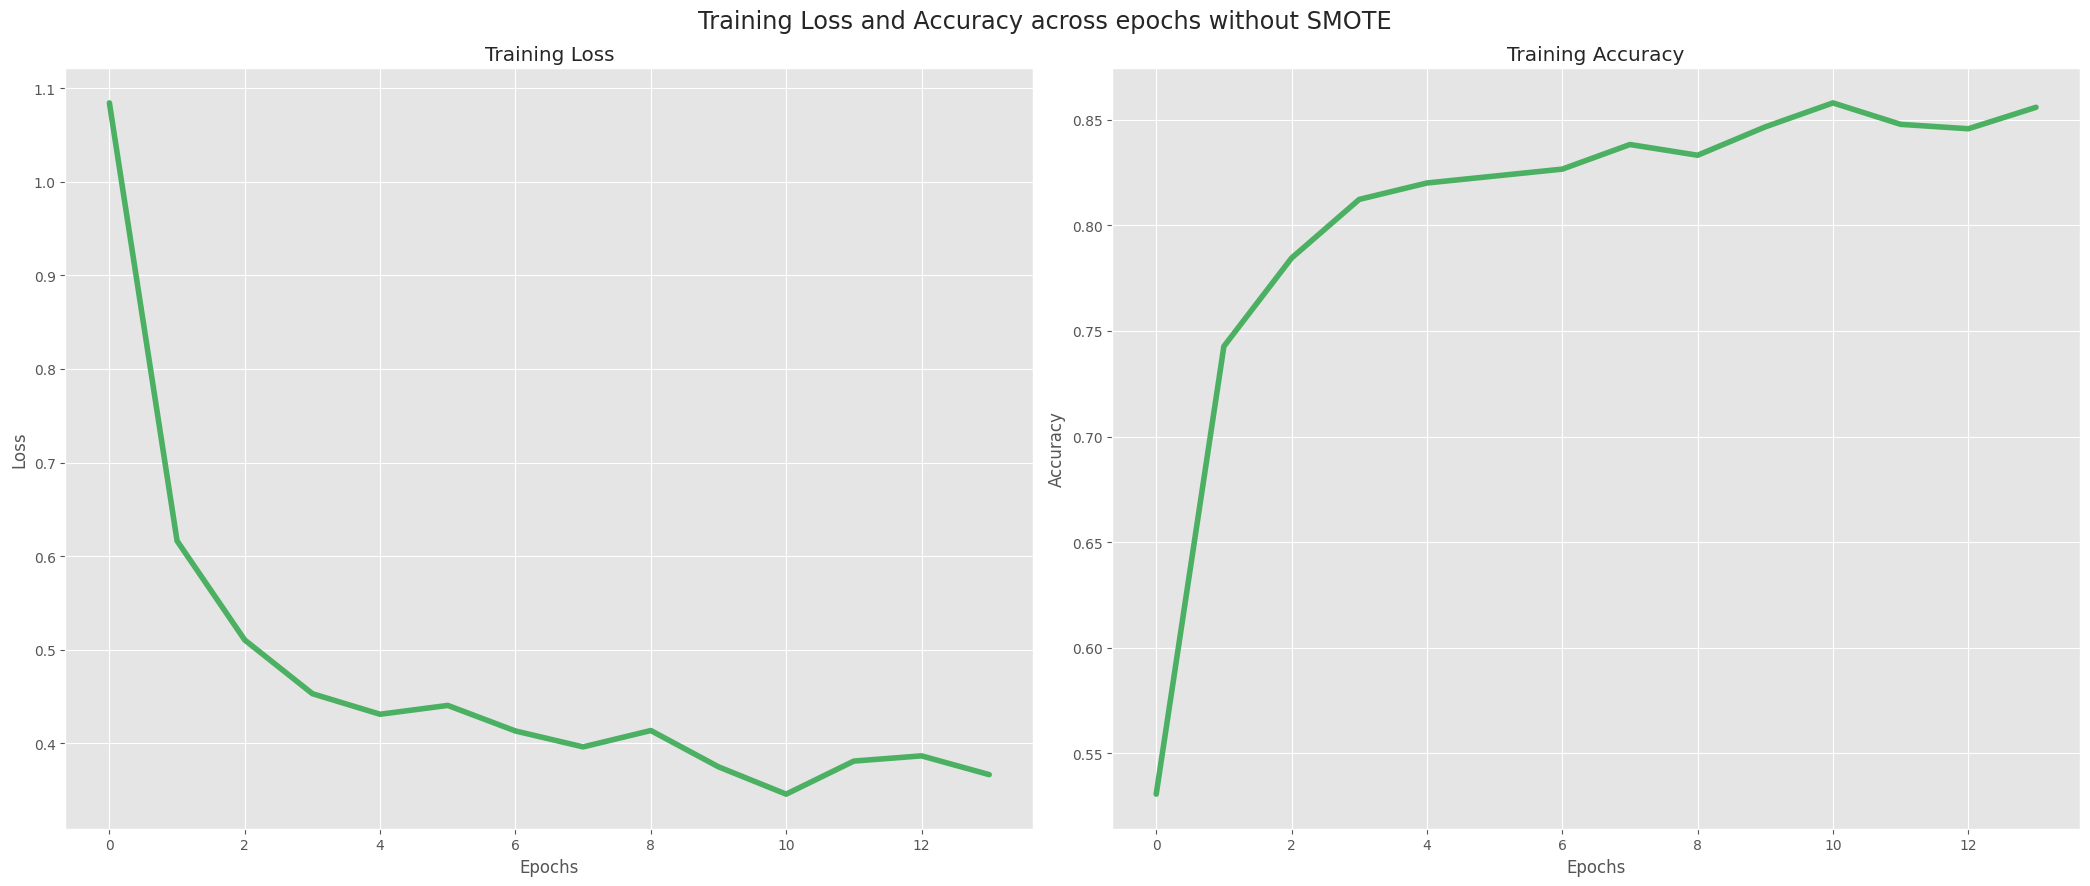

In [97]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9), tight_layout=True)

history_df_no_SMOTE['loss'].plot(ax = ax1, linewidth = 4, color = palette[2])

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')

history_df_no_SMOTE['accuracy'].plot(ax = ax2, linewidth = 4, color = palette[2])

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')

plt.suptitle('Training Loss and Accuracy across epochs without SMOTE', size='xx-large')


# Show the plot
plt.show()

In [80]:
classifier_no_SMOTE.evaluate(valX, Y_val)

27/27 [==============================] - 0s 12ms/step - loss: 1.5488 - accuracy: 0.6814


[1.548831582069397, 0.681384265422821]

In [77]:
prediction_no_SMOTE = classifier_no_SMOTE.predict(valX)

27/27 [==============================] - 0s 10ms/step


In [78]:
predictions = prediction_no_SMOTE.argmax(axis=1)
prediction_labels = []
for n in predictions:
    prediction_labels.append(from_number_to_label(n))

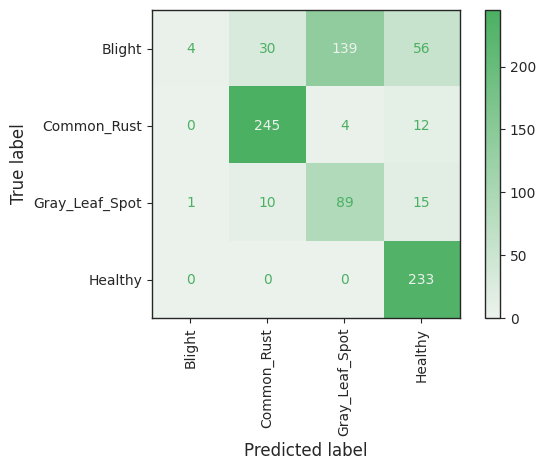

In [79]:
cmap = sns.light_palette(color=sns.color_palette("Greens", 4)[2], as_cmap=True)
sns.set_style("ticks")
ConfusionMatrixDisplay.from_predictions(y_true=actual_test_labels,
                                        y_pred=prediction_labels,
                                        cmap=cmap,
                                        xticks_rotation=90,
                                       )
plt.tight_layout()
plt.show()

### VGGNet16 - Transfer Learning

As second and last model for this project we decided to give it a try with a pre-trained CNN (in this case we tried with VGG16 with imagenet weights) in order to perform transfer learning.
We clearly known in advance that the performance would have been better than ours but in few cells you can see why in this case this is not a right choice

In [87]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

secondary_model = Flatten()(base_model.output)
secondary_model = Dense(4, activation='softmax')(secondary_model)

combined_model = Model(inputs=base_model.input, outputs=secondary_model)

combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [59]:
combined_model.summary()

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 56, 56, 1

In [88]:
history_transfer = combined_model.fit(X_smote, Y_train, batch_size=32, epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50
131/131 [==============================] - 17s 91ms/step - loss: 0.5847 - accuracy: 0.7976
Epoch 2/50
131/131 [==============================] - 9s 67ms/step - loss: 0.3758 - accuracy: 0.9175
Epoch 3/50
131/131 [==============================] - 9s 67ms/step - loss: 0.3957 - accuracy: 0.9258
Epoch 4/50
131/131 [==============================] - 9s 68ms/step - loss: 0.2723 - accuracy: 0.9359
Epoch 5/50
131/131 [==============================] - 9s 67ms/step - loss: 0.1680 - accuracy: 0.9689
Epoch 6/50
131/131 [==============================] - 9s 67ms/step - loss: 0.2107 - accuracy: 0.9519
Epoch 7/50
131/131 [==============================] - 9s 67ms/step - loss: 0.2172 - accuracy: 0.9806
Epoch 8/50
131/131 [==============================] - 9s 68ms/step - loss: 0.1166 - accuracy: 0.9711
Epoch 9/50
131/131 [==============================] - 9s 67ms/step - loss: 0.1238 - accuracy: 0.9823
Epoch 10/50
131/131 [==============================] - 9s 68ms/step - loss: 0.1636 - accur

In [89]:
combined_model.evaluate(valX, Y_val)

27/27 [==============================] - 3s 113ms/step - loss: 46.3054 - accuracy: 0.8950


[46.30543518066406, 0.8949880599975586]

As we can see the network performs very well, but we can also see extremely high accuracy on the training set with slightly less on the validation. This could mean a little overfitting and also considering the complexity of the model related to the task it is not suggested to use such a model.

In [90]:
prediction_VGG = combined_model.predict(valX)

27/27 [==============================] - 2s 63ms/step


In [93]:
predictions_VGG = prediction_VGG.argmax(axis=1)
prediction_labels_VGG = []
for n in predictions_VGG:
    prediction_labels_VGG.append(from_number_to_label(n))

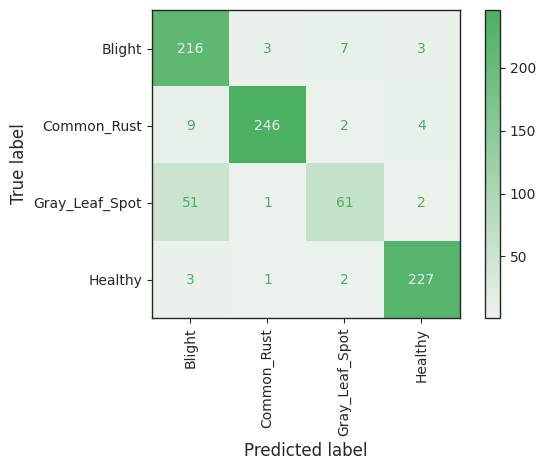

In [95]:
cmap = sns.light_palette(color=sns.color_palette("Greens", 4)[2], as_cmap=True)
sns.set_style("ticks")
ConfusionMatrixDisplay.from_predictions(y_true=actual_test_labels,
                                        y_pred=prediction_labels_VGG,
                                        cmap=cmap,
                                        xticks_rotation=90,
                                       )
plt.tight_layout()
plt.show()